In [25]:
!mkdir -p ~/.kaggle      # setting the directory of kaggle
!cp kaggle.json ~/.kaggle/

In [26]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset # downloading the dataset from kaggle

face-mask-12k-images-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [27]:
!chmod 600 /root/.kaggle/kaggle.json

In [28]:
import zipfile          # Unzipping the file download from kaggle
zip_ref = zipfile.ZipFile('/content/face-mask-12k-images-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [29]:
import tensorflow as tf    # importing the dependencies
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D,Dense,MaxPooling2D,Flatten,BatchNormalization,Dropout
from keras.applications.vgg16 import VGG16

In [30]:
#Making object of VGG16
conv_base=VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(256,256,3)
)

In [31]:
#summary of the model
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [32]:
# Freezing the model
conv_base.trainable=False

In [33]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [34]:
# Adding the ANN part to the end of VGG16
model=Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1,activation="sigmoid"))

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               8388864   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 23,103,809
Trainable params: 8,389,121
Non-trainable params: 14,714,688
_________________________________________________________________


In [38]:
#Making Train and Test data

train_data = keras.utils.image_dataset_from_directory(
    directory="/content/Face Mask Dataset/Train",
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(256,256)
)
test_data=keras.utils.image_dataset_from_directory(
    directory="/content/Face Mask Dataset/Test",
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(256,256)
)



Found 10000 files belonging to 2 classes.
Found 992 files belonging to 2 classes.


In [39]:
# Standardizing the image size
def process(image,label):
  image=tf.cast(image/255,tf.float32)

  return image,label

train_data=train_data.map(process)
#test_data=test_data.map(process)

In [40]:
# compiling the model
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [43]:
# train the model
history=model.fit(train_data,epochs=5,validation_data = (test_data))

Epoch 1/5
313/313 [==============================] - 69s 218ms/step - loss: 0.0280 - accuracy: 0.9897 - val_loss: 0.4838 - val_accuracy: 0.9929
Epoch 2/5
313/313 [==============================] - 61s 192ms/step - loss: 0.0152 - accuracy: 0.9941 - val_loss: 0.8778 - val_accuracy: 0.9899
Epoch 3/5
313/313 [==============================] - 61s 192ms/step - loss: 0.0187 - accuracy: 0.9924 - val_loss: 1.0321 - val_accuracy: 0.9889
Epoch 4/5
313/313 [==============================] - 64s 203ms/step - loss: 0.0128 - accuracy: 0.9953 - val_loss: 0.8287 - val_accuracy: 0.9909
Epoch 5/5
313/313 [==============================] - 60s 190ms/step - loss: 0.0085 - accuracy: 0.9970 - val_loss: 0.5315 - val_accuracy: 0.9899


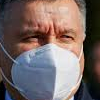

1/1 [==============================] - 0s 29ms/step
With Mask


In [49]:
# testing the model with some random images
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("/content/Face Mask Dataset/Validation/WithMask/1002.png")

cv2_imshow(img)

def prediction(img):
  img_sh=cv2.resize(img,(256,256))
  test_img=img_sh.reshape((1,256,256,3))

  output=model.predict(test_img)
  ot=int(output[0][0])

  if ot == 0:

    print("With Mask")

  else:
    print("Without Mask")

prediction(img)

In [50]:
import pickle

pickle.dump(model,open('facemask detection model.pkl','wb'))

In [51]:

tf.keras.models.save_model(model,"my_model.hdf5")